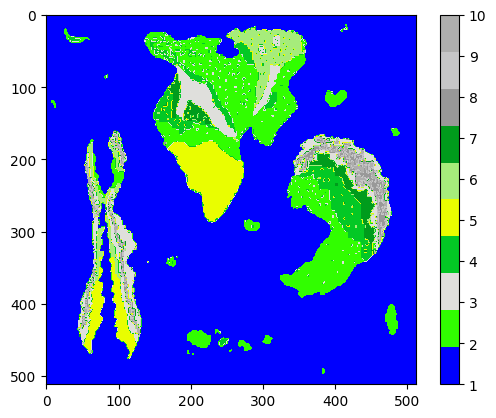

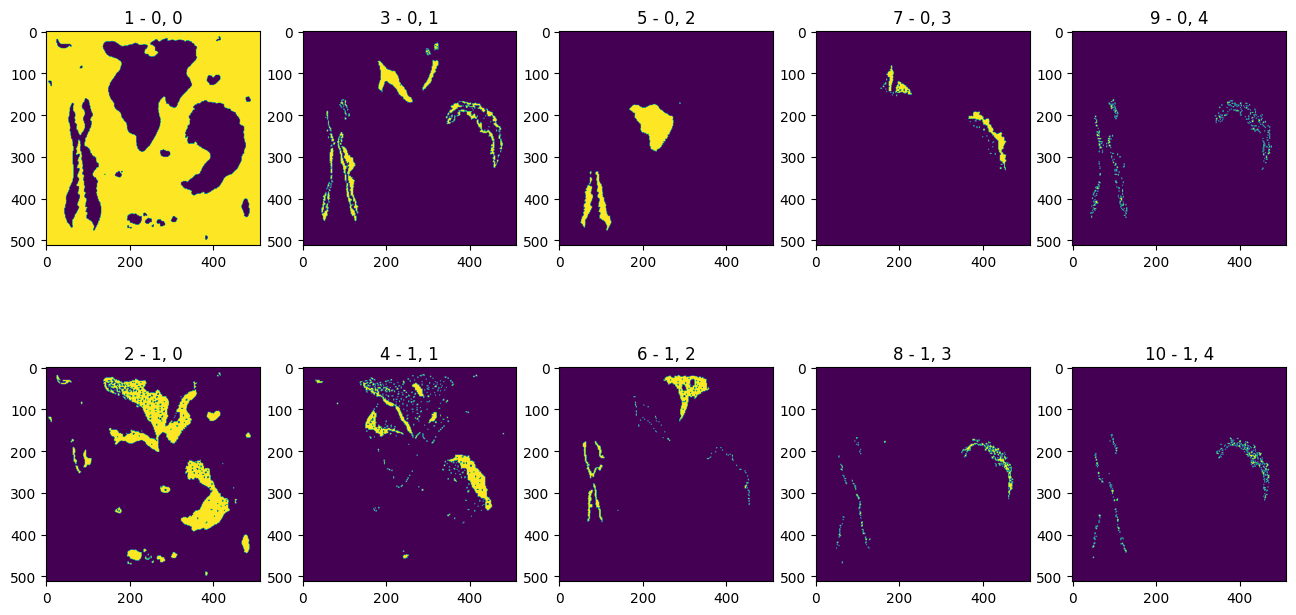

In [1]:
from worldgen.image import load_image, patch, extract_biomes
from worldgen.visualization import colormap_biomes, visualize_biomes
import numpy as np
import matplotlib.pyplot as plt

goal = 65536
base = 512
scale = base * 128
patches = 8
biome_count = 10

world_image = load_image("./assets/pinnacle.png", base)
world, biomes = extract_biomes(world_image, biome_count)

visualize_biomes(world, biomes, base)
world_map = world['label'].values.reshape(base, base)
fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i, b in enumerate(biomes.index[:-1]):
    v, u = i // 2, i % 2
    ax[u, v].set_title(f'{b} - {u}, {v}')
    ax[u, v].imshow(world_map == b)


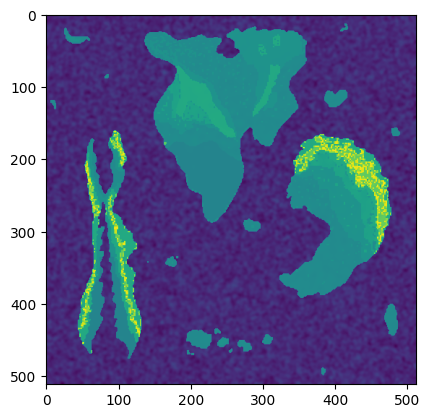

In [2]:
# We need to fit a heightmap to our world map.  There are 10 biomes:
# 1 - Ocean
# 2 - Grassland
# 3 - Hills
# 4 - Woodland
# 5 - Desert
# 6 - Tundra
# 7 - Forest
# 8 - Mountain
# 9 - Alpine
# 10 - Peaks
import numpy as np
from scipy.ndimage import gaussian_filter
from worldgen.heightmap import apply_gaussian_noise


# The biome_rules have been completed with some assumptions
biome_rules = {
    1: {'min_height': -100, 'max_height': 0, 'alpha': 2, 'clip': True},  # Ocean
    2: {'min_height': 0, 'max_height': 20, 'alpha': 3, 'clip': True},  # Grassland
    3: {'min_height': 20, 'max_height': 40, 'alpha': 4, 'clip': True},  # Hills
    4: {'min_height': 10, 'max_height': 20, 'alpha': 3, 'clip': False},  # Woodland
    5: {'min_height': 0, 'max_height': 10, 'alpha': 5, 'clip': True},  # Desert
    6: {'min_height': 10, 'max_height': 20, 'alpha': 4, 'clip': True},  # Tundra
    7: {'min_height': 10, 'max_height': 40, 'alpha': 3, 'clip': False},  # Forest
    8: {'min_height': 40, 'max_height': 70, 'alpha': 2, 'clip': True},  # Mountain
    9: {'min_height': 60, 'max_height': 80, 'alpha': 1, 'clip': True},  # Alpine
    10: {'min_height': 80, 'max_height': 100, 'alpha': 1, 'clip': True}  # Peaks
}

def generate_heightmap(zone_map : np.ndarray, passes: int=3) -> np.ndarray:
    """This function generates a heightmap from a world map."""
    heightmap = np.zeros_like(zone_map, dtype=np.float32)

    # Multiple passes over the same map for smoothing
    for _ in range(passes):
        for biome, rules in biome_rules.items():
            mask = zone_map == biome
            random_heights = np.random.uniform(rules['min_height'], rules['max_height'], size=zone_map.shape)
            
            # apply the smoothing with a sigma specific to the biome
            smoothed_heights = gaussian_filter(random_heights, sigma=rules['alpha'])
            
            # Enforce minimum and maximum heights if 'clip' rule is True
            if rules['clip']:
                smoothed_heights = np.clip(smoothed_heights, rules['min_height'], rules['max_height'])
            
            # only apply smoothed heights to the respective biome
            heightmap[mask] = smoothed_heights[mask]

    return heightmap

hm = generate_heightmap(world_map, 1)
plt.imshow(hm)


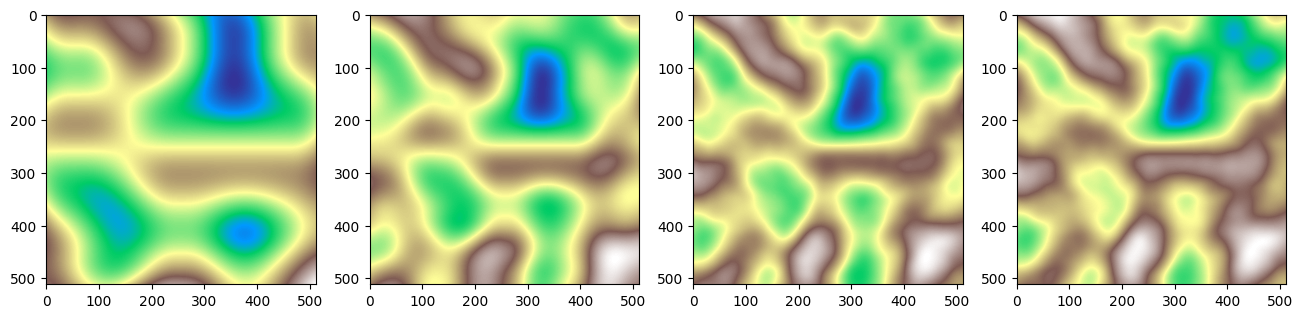

In [3]:
import noise
import math


from worldgen.heightmap import init_heightmap, apply_fractal_noise

gh = init_heightmap(world_map.shape)
# smooth, large [1, .005, 4.8, .5]
# smooth, medium [1, .008, 4.1, .9]
# small, rough [5, .039, 2.4, .7]
# med, textured [6, .014, 5, .7]
levels = [
    [1, .005, 4.8, .5],
    [1, .008, 4.1, .9],
    [5, .039, 2.4, .7],
    [6, .014, 5, .7],
]
fig, ax = plt.subplots(1, len(levels), figsize=(16, 8))
for i, (octaves, scale, persistence, lacunarity) in enumerate(levels):
    gh = apply_fractal_noise(gh.copy(), (0, 0), octaves, scale, persistence, lacunarity)
    ax[i].imshow(gh, cmap='terrain')




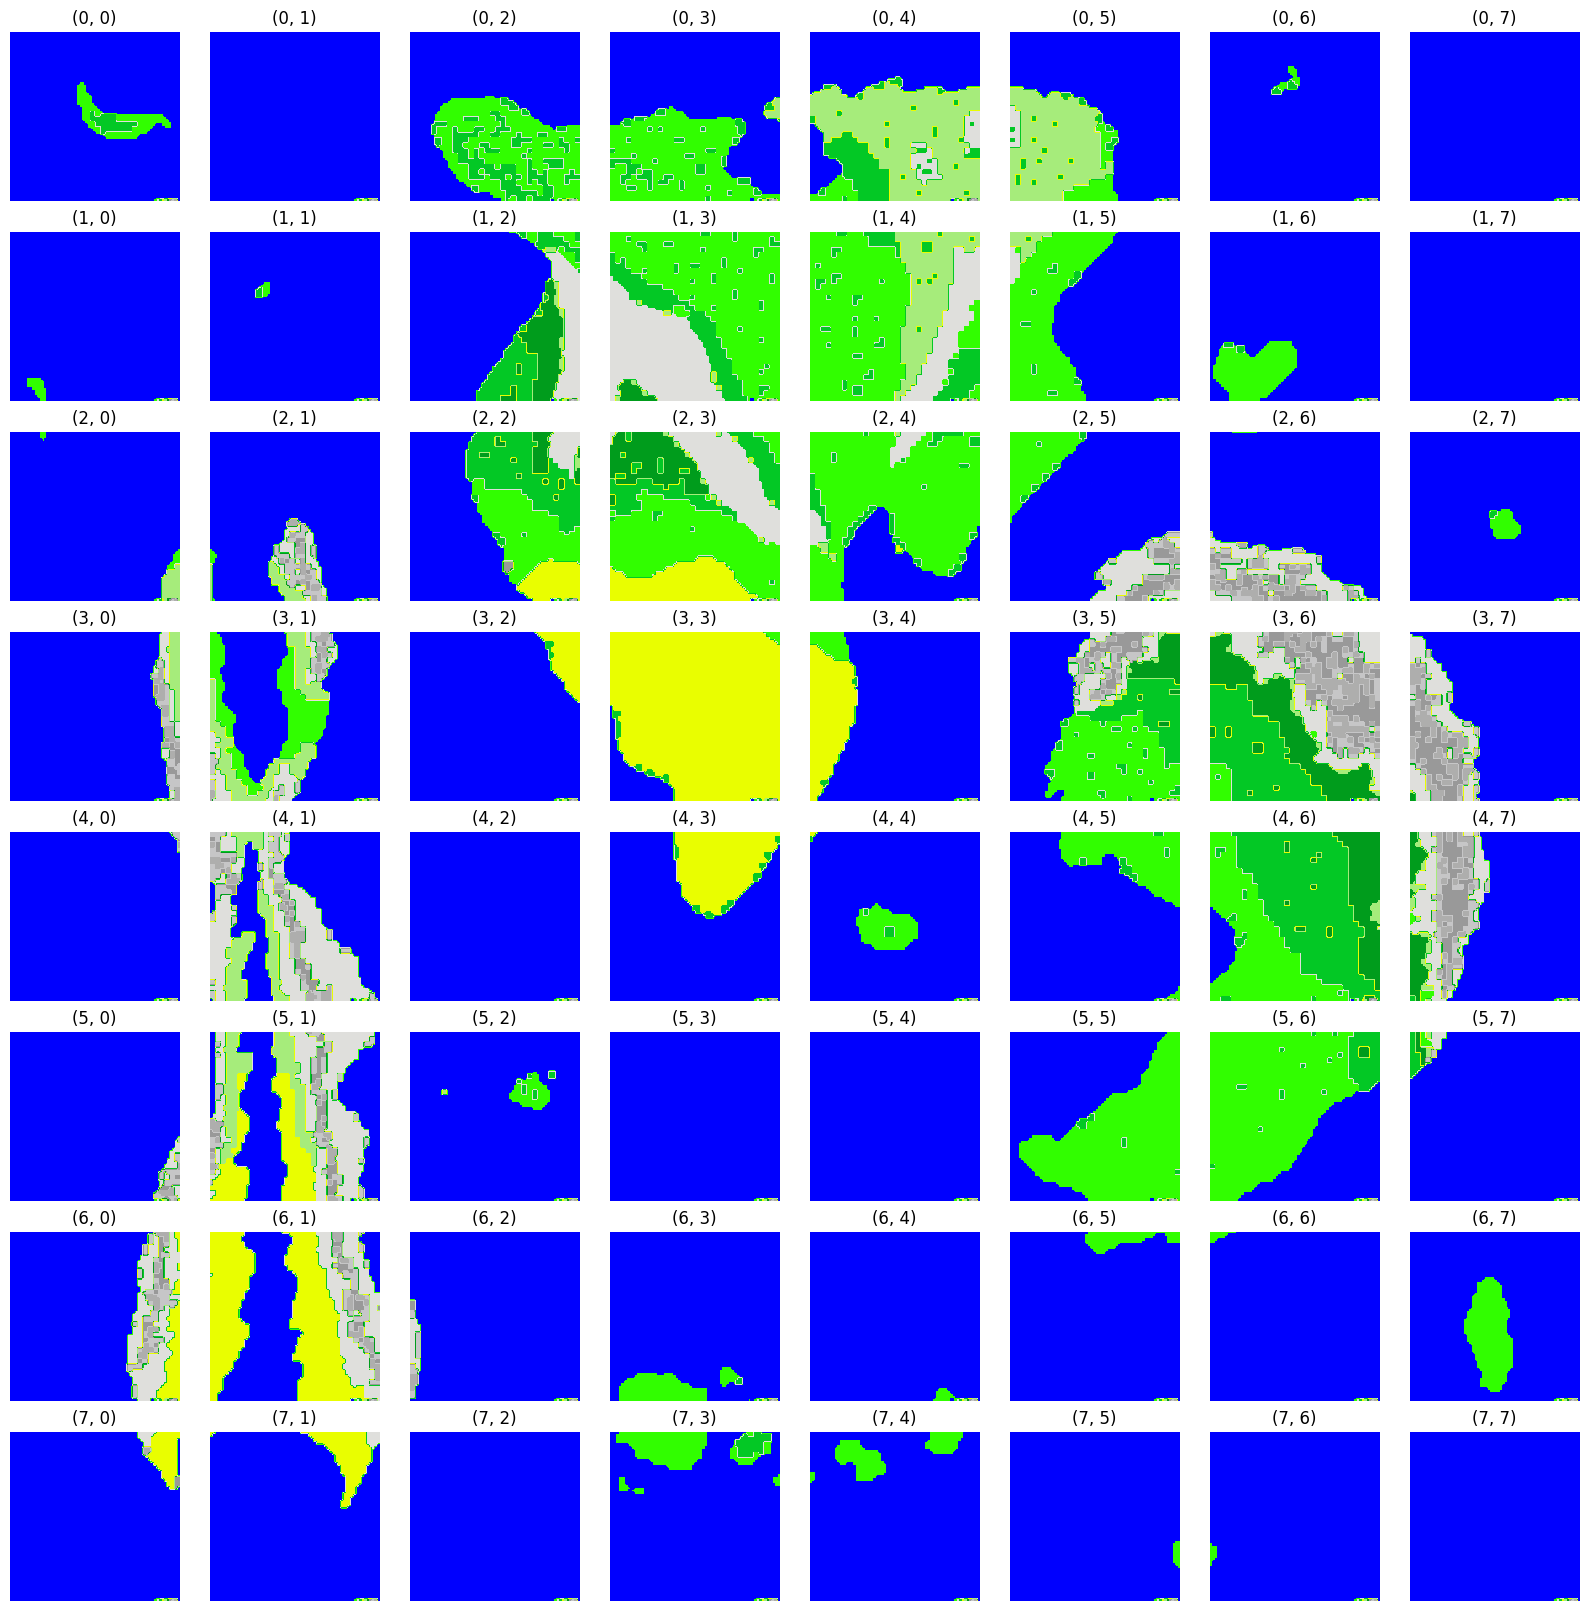

In [2]:
cmap = colormap_biomes(biomes)
biome_map = world['label'].values.reshape(base, base, 1)

# Create an 8x8 figure, minimize the margins, and set the spacing to 0
fig, ax = plt.subplots(patches, patches, figsize=(16, 16), constrained_layout=True, squeeze=False)

# Iterate over the axes and plot the patches
for i in range(0, patches):
    for j in range(0, patches):
        segment = patch(i, j, biome_map, int(base / patches)).copy()

        segment[-1, -biome_count-1:-1, 0] = biomes.index.values[:-1]
        ax[i, j].imshow(segment, cmap=cmap)
        ax[i, j].axis('off')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title(f'({i}, {j})')


plt.show()

In [ ]:
world

In [ ]:
from worldgen.voronoi import get_voronoi, voronoi_finite_polygons_2d, clip_to_bounds, rasterize_voronoi
from worldgen.voronoi import LoG_erode
from worldgen.visualization import visualize_zones

patch_window = int(base / patches)
patch_image = patch(2, 4, biome_map, patch_window)
patch_image = np.flip(patch_image, 0)
points, voronoi = get_voronoi(6096)
regions, vertices = voronoi_finite_polygons_2d(voronoi)
polygons = clip_to_bounds(regions, vertices, (0, 1), (0, 1))
vzones = rasterize_voronoi(polygons, patch_image, patch_window, patch_window * 8)
vzones = LoG_erode(vzones, biomes, 1, 0, 4)
visualize_zones(vzones, biomes, patch_window / 2)

In [ ]:
from worldgen.heightmap import config_gen, init_heightmap, for_direction, generate_tiers

def build_heightmap(direction : str, base : int = 512, param : int = 1):
    hm_config = config_gen(size=(base, base))
    heightmap = init_heightmap(**hm_config)
    return generate_tiers(for_direction(heightmap, direction, param, **hm_config), **hm_config)


In [ ]:
kzones = cvzones.copy()
def fractal_erode(zone_map : np.ndarray, threshold : int = 11) -> np.ndarray:
    zones = zone_map.copy().astype(float)
    heightmap = build_heightmap('NW', base, 2)
    height_mask = heightmap >= threshold
    zones[height_mask] = np.nan
    zones = binary_fill_holes(zones)
    fig, ax = plt.subplots(1, 2, figsize=(12, 12))
    ax[0].imshow(height_mask, cmap=cmap)
    ax[1].imshow(zones, cmap=cmap)
    plt.show()
    return zones.astype(int)

for z in range(10, 2, -1):
    kzones = fractal_erode(kzones, 12)

fig, ax = plt.subplots(1, 2, figsize=(12, 12))
#ax.imshow(cvzones, cmap=cmap)
#ax.imshow(cvzones, cmap=cmap, alpha=0.25)
kzones[-1, -biome_count-1:-1] = biomes.index.values[:-1]
ax[0].imshow(cvzones, cmap=cmap)
ax[1].imshow(kzones, cmap=cmap)
#ax.imshow(heightmap_b, cmap='gray', alpha=0.25)